In [1]:
#@authors: Isabel Burgos, Francesca Drummer, Lennart Geertjes, Madelief Rennspies, Ellen Schrader
# for inline plots in jupyter
%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(4.5,3)})
# import distributions
from scipy.stats import *
import numpy as np

In [2]:
#This function returns the feature of the tile flipped and the object below it. 
#Theta = vector of category probabilities of the features
#Psi = vector of category probabilities of the objects given the features (deterministic)
#The number of objects n and features k is included implicitly in the size of the corresponding arrays
def environment(theta,psi):
    #Draw feature from a categorical distribution
    feature = np.array(multinomial.rvs(p = theta,n = 1))
    
    #Draw the object from a categorical distribution given the feature
    obj     = multinomial.rvs(p = psi[feature==1].flatten(), n=1)
    
    #Get index of object and feature (starting at 0)
    idx_feature = list(feature).index(1)
    idx_object  = list(obj).index(1)
    
    return idx_feature, idx_object

In [3]:
#Model of the agent. The function returns the predicted probability distribution over the objects given the features
#and the index of the predicted object
#Note: we might not need the predicted object and the index of the object itself but it is still included as it might
#be useful for some of us
def agent(psi,alpha,idx_feature):
    psi[idx_feature,:] = dirichlet.rvs(alpha[idx_feature,:])
    obj = multinomial.rvs(p=psi[idx_feature,:], n=1)
    idx_object  = list(obj).index(1)
    return psi, idx_object

In [4]:
#The agent learns the probability distribution of the objects given a specific feature
#n_iter = the number of iterations in this observations the agent sees
#n_objects = the number of objects
#n_features = the number of features and thus also of tiles

def trial(n_iter, n_objects, n_features, psi_env):
    ####Initial values###
    alpha = np.full((n_features,n_objects),1)
    pre_errors = [[]]*n_features
    psi_agent = np.full((n_features,n_objects), 1/n_objects)
    #If you want specific features to occur more often change e.g., to theta = [0.8,0.1,0.1]
    theta = np.repeat(1/n_features,n_features)
    
    ###Updating the agent's generative model###
    for i in range(0,n_iter):
        
        #Get feature and observation from environment
        idx_feature, idx_object = environment(theta,psi_env)
        
        #Prediction of the agent
        psi_agent, _ =  agent(psi_agent,alpha,idx_feature)
        
        #Calculate prediction error using relative entropy (Kullback-Leibler divergence)
        pre_err=round(entropy(psi_agent[idx_feature,:],psi_env[idx_feature,:], base=None),5)
        pre_errors[idx_feature].append(pre_err)
        
        #Updating hyperparameters
        alpha[idx_feature, idx_object]+=1    
    return alpha, pre_errors

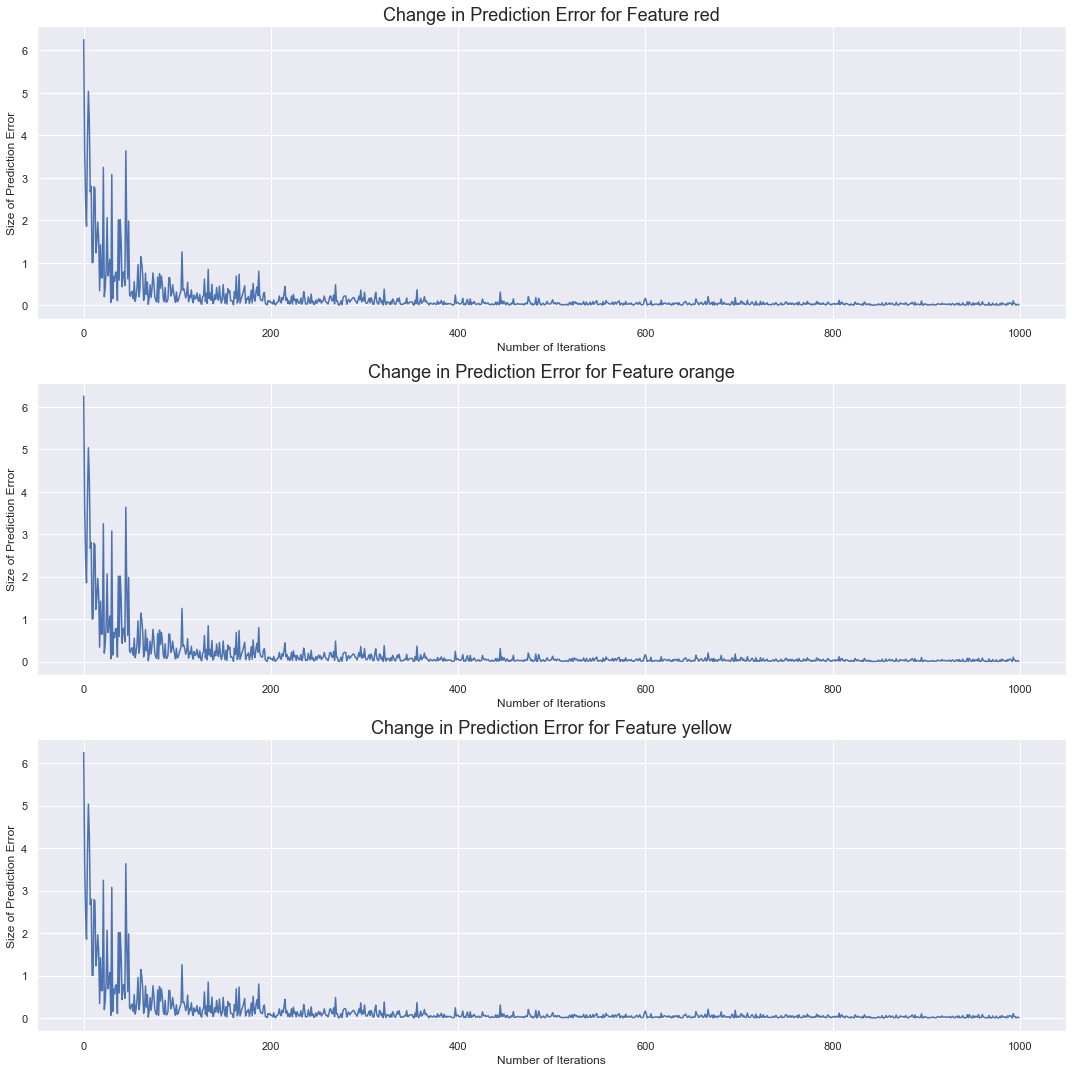

In [5]:
###Running the simulation###

#The environment is supposed to be deterministic but 
#due to the nature of Kullback Leibler divergence the probabilities cannot be zero.
psi_env = np.array([[0.9999,0.00005,0.00005],[0.00005,0.00005,0.9999],[0.00005,0.9999,0.00005]])
f_names = ["red", "orange", "yellow"]
o_names = ["circle", "square", "triangle"]
alpha, pre_errors =trial(1000,3,3,psi_env)

fig, ax = plt.subplots(3, 1, figsize=(15,15))
for i in range(0,3):
    ax[i].plot(pre_errors[i])
    ax[i].set_title("Change in Prediction Error for Feature {}".format(f_names[i]), fontsize=18)    
    ax[i].set_xlabel("Number of Iterations")
    ax[i].set_ylabel("Size of Prediction Error")
fig.tight_layout()    